In [1]:


##############################################################################
# 1) INSTALL DEPENDENCIES
##############################################################################
!pip install faiss-cpu sentence-transformers scikit-learn matplotlib seaborn transformers accelerate





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 46.4 MB/s eta 0:00:00:00:0100:01


In [2]:
##############################################################################
# 2) IMPORTS
##############################################################################
import faiss
import numpy as np
import textwrap
import re
import torch

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
##############################################################################
# 3) INITIALIZE MODELS
##############################################################################
# 3.1) Embedding model
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# 3.2) DeepSeek LLM
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-llm-7b-chat")
model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/deepseek-llm-7b-chat",
    torch_dtype=torch.float16,
    device_map="auto",
    offload_folder="offload"


)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [4]:
##############################################################################
# 4) DEFINE DOCUMENTS
##############################################################################
documents = [
    {
        "id": "best_practice",
        "text": """Best practice color guide:
- Bedroom parents – Brown
- Bedroom girls – Pink
- Bedroom boy – Blue
- Bathroom – White
- Living room – Beige
"""
    },
    {
        "id": "house1",
        "text": """House 1:
- Bedroom parents – Black
- Bedroom girl – Yellow
- Bathroom – Green
- Living room – Beige
"""
    },
    {
        "id": "house2",
        "text": """House 2:
- Bedroom parents – Brown
- Bedroom girls – Pink
- Bedroom boy – Blue
- Bathroom – Green
- Living room – Beige
"""
    }
]
test_data = [
    {
        "query": "Is House 1 correctly painted according to best practice?",
        "label": 0
    },
    {
        "query": "Is House 2 correctly painted according to best practice?",
        "label": 0
    },
    {
        "query": "Which house follows best practice for living rooms?",
        "label": 1
    },
    {
        "query": "What color should a boy's bedroom be?",
        "label": 1
    }
]

In [5]:
##############################################################################
# 5) BUILD FAISS INDEX
##############################################################################
texts = [doc["text"] for doc in documents]
doc_ids = [doc["id"] for doc in documents]

embeddings = embed_model.encode(texts, convert_to_numpy=True)
embedding_dim = embeddings.shape[1]

index = faiss.IndexFlatL2(embedding_dim)
index.add(embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
##############################################################################
# 6) RETRIEVAL & GENERATION FUNCTIONS
##############################################################################
def retrieve_faiss(query, model, index, doc_ids, texts, top_k=3):
    query_vec = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_vec, top_k)
    return [{
        "id": doc_ids[i],
        "text": texts[i],
        "distance": distances[0][rank]
    } for rank, i in enumerate(indices[0])]

def generate_answer(query, context):
    prompt = f"""<｜begin▁of▁sentence｜>You are a helpful design assistant. Answer using the context below.

Context:
{context}

Question: {query}

Answer:"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).split("Answer:")[-1].strip()

def parse_correctness(answer):
    answer_lower = answer.lower()
    positive_terms = ['correct', 'match', 'yes', 'proper']
    negative_terms = ['incorrect', 'mismatch', 'no', 'wrong']
    positive_count = sum(term in answer_lower for term in positive_terms)
    negative_count = sum(term in answer_lower for term in negative_terms)
    return 1 if positive_count > negative_count else 0

In [7]:
##############################################################################
# 7) PARSING & COMPARISON LOGIC
##############################################################################
def parse_color_lines(text):
    color_map = {}
    for line in text.split("\n"):
        if line.startswith("- "):
            parts = re.split(r'–|-', line[2:], maxsplit=1)
            if len(parts) == 2:
                room = parts[0].strip().lower()
                color = parts[1].strip().lower()
                color_map[room] = color
    return color_map

def compare_houses(house1_text, house2_text, best_practice_text):
    guide_map = parse_color_lines(best_practice_text)
    h1_map = parse_color_lines(house1_text)
    h2_map = parse_color_lines(house2_text)

    report = ["Comparison of House 1 and House 2 with Best Practice:\n"]
    mismatch1 = mismatch2 = 0

    for room, ideal_color in guide_map.items():
        h1_color = h1_map.get(room, "N/A")
        h2_color = h2_map.get(room, "N/A")

        report.extend([
            f"Room: {room.title()}",
            f"  Best Practice: {ideal_color}",
            f"  House 1: {h1_color} ({'✅' if h1_color == ideal_color else '❌'})",
            f"  House 2: {h2_color} ({'✅' if h2_color == ideal_color else '❌'})\n"
        ])

        mismatch1 += h1_color != ideal_color
        mismatch2 += h2_color != ideal_color

    conclusion = (
        f"House 1 mismatches: {mismatch1} | House 2 mismatches: {mismatch2}\n"
        f"Conclusion: {'House 1' if mismatch1 < mismatch2 else 'House 2'} is closer to best practice"
        if mismatch1 != mismatch2 else "Both houses have equal mismatches"
    )
    report.append(conclusion)
    return "\n".join(report)

In [8]:
##############################################################################
# 8) RAG ANSWER FUNCTION
##############################################################################
def rag_answer(query, embed_model, index, doc_ids, texts, top_k=3):
    # Special case handling for comparison queries
    if "compare house" in query.lower():
        retrieved = retrieve_faiss(query, embed_model, index, doc_ids, texts, 3)
        docs = {doc['id']: doc['text'] for doc in retrieved}
        return compare_houses(
            docs.get('house1', documents[1]['text']),
            docs.get('house2', documents[2]['text']),
            docs.get('best_practice', documents[0]['text'])
        )

    # General case: Retrieve + Generate
    retrieved = retrieve_faiss(query, embed_model, index, doc_ids, texts, top_k)
    context = "\n\n".join(doc['text'] for doc in retrieved)
    return generate_answer(query, context)

In [48]:
##############################################################################
# 7) EVALUATION FRAMEWORK
##############################################################################
def evaluate_agent(y_true, y_pred):
    if not y_true or not y_pred:
        print("No data available for evaluation.")
        return

    # Calculate metrics
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_pred) if len(set(y_true)) > 1 else "N/A",
        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "classification_report": classification_report(y_true, y_pred)
    }

    # Plotting
    plt.figure(figsize=(10, 4))

    # Confusion Matrix Heatmap
    plt.subplot(1, 2, 1)
    sns.heatmap(metrics["confusion_matrix"], annot=True, fmt="d", cmap="Blues",
                xticklabels=['Incorrect', 'Correct'], yticklabels=['Incorrect', 'Correct'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Metrics Bar Chart
    plt.subplot(1, 2, 2)
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']
    metric_values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']]
    sns.barplot(x=metric_names, y=metric_values, palette="viridis")
    plt.ylim(0, 1)
    plt.title("Performance Metrics")

    plt.tight_layout()
    plt.show()

    # Print textual reports
    print("Classification Report:")
    print(metrics["classification_report"])

    print("\nROC AUC Score:", metrics["roc_auc"])

Design Assistant initialized!


Enter your design questions (type 'exit' to quit):



Question:  Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly
Retrieved Context:
Best practice color guide: - Bedroom parents – Brown - Bedroom girls – Pink - Bedroom boy – Blue -
Bathroom – White - Living room – Beige   House 1: - Bedroom parents – Black - Bedroom girl – Yellow
- Bathroom – Green - Living room – Beige   House 2: - Bedroom parents – Brown - Bedroom girls – Pink
- Bedroom boy – Blue - Bathroom – Green - Living room – Beige
--------------------------------------------------
Answer:
House 1: - Bedroom parents painted correctly: Yes - Bedroom girl painted correctly: No - Bathroom
painted correctly: Yes - Living room painted correctly: Yes  House 2: - Bedroom parents painted
correctly: Yes - Bedroom girl painted correctly: Yes - Bathroom painted correctly: Yes - Living room
painted correctly: Yes  Both house 1 and house 2 have been painted correctly according to the best
practice color guide. The only difference is tha

Was the answer correct? (1 for Yes, 0 for No):  0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

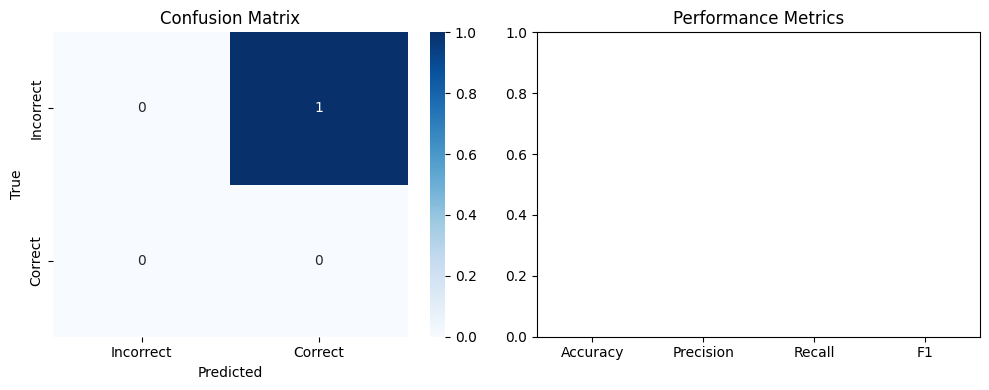

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0


ROC AUC Score: N/A



Question:  Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly
Retrieved Context:
Best practice color guide: - Bedroom parents – Brown - Bedroom girls – Pink - Bedroom boy – Blue -
Bathroom – White - Living room – Beige   House 1: - Bedroom parents – Black - Bedroom girl – Yellow
- Bathroom – Green - Living room – Beige   House 2: - Bedroom parents – Brown - Bedroom girls – Pink
- Bedroom boy – Blue - Bathroom – Green - Living room – Beige
--------------------------------------------------
Answer:
House 1 and House 2 have both been painted correctly according to the best practice color guide. In
House 1, the Bedroom Parents are painted in the correct color, which is Brown, while the Living Room
is also painted with the recommended Beige color. The Bathroom is painted with the correct Green
color, and the Bedroom Girl's color is Yellow, which is also a correct choice.  In House 2, the
Bedroom Parents are also painted with the correc

Was the answer correct? (1 for Yes, 0 for No):  0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

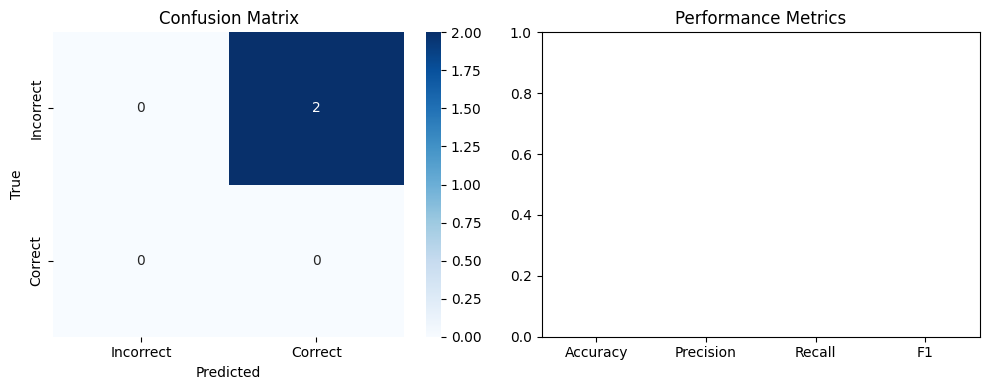

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0


ROC AUC Score: N/A



Question:  Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly
Retrieved Context:
Best practice color guide: - Bedroom parents – Brown - Bedroom girls – Pink - Bedroom boy – Blue -
Bathroom – White - Living room – Beige   House 1: - Bedroom parents – Black - Bedroom girl – Yellow
- Bathroom – Green - Living room – Beige   House 2: - Bedroom parents – Brown - Bedroom girls – Pink
- Bedroom boy – Blue - Bathroom – Green - Living room – Beige
--------------------------------------------------
Answer:
House 1 and House 2 both have some deviations from the best practice color guide. While House 1 has
followed the color guide for the bedroom boy, bedroom girl, and bathroom, it deviates from the
recommended color for the bedroom parents (Black instead of Brown) and the living room (Black
instead of Beige).  House 2, on the other hand, follows the best practice color guide for the
majority of the rooms, but deviates from the guide for the 

Was the answer correct? (1 for Yes, 0 for No):  Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly


Invalid input. Enter 1 for Yes or 0 for No.


Was the answer correct? (1 for Yes, 0 for No):  0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique 

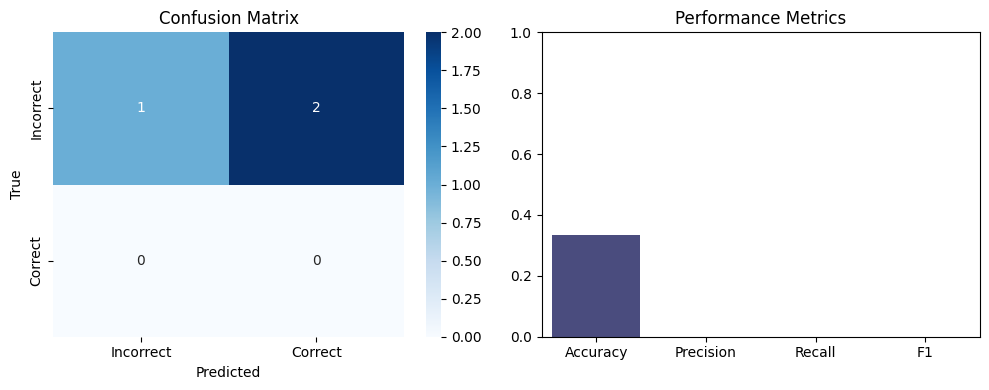

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.00      0.00      0.00         0

    accuracy                           0.33         3
   macro avg       0.50      0.17      0.25         3
weighted avg       1.00      0.33      0.50         3


ROC AUC Score: N/A



Question:  Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: Compare house 1 and house 2 with the best practice color guide and advise if they have been painted correctly
Retrieved Context:
Best practice color guide: - Bedroom parents – Brown - Bedroom girls – Pink - Bedroom boy – Blue -
Bathroom – White - Living room – Beige   House 1: - Bedroom parents – Black - Bedroom girl – Yellow
- Bathroom – Green - Living room – Beige   House 2: - Bedroom parents – Brown - Bedroom girls – Pink
- Bedroom boy – Blue - Bathroom – Green - Living room – Beige
--------------------------------------------------
Answer:
House 1 has followed the best practice color guide for the most part, with the exception of using
yellow instead of pink for the bedroom girl. However, the overall color scheme is still cohesive and
follows the recommended guidelines.  House 2 has also followed the best practice color guide for the
most part, but the use of green in the bathroom and living room deviates from the recommended
colors. The green may clash with the beige, crea

Was the answer correct? (1 for Yes, 0 for No):  1


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


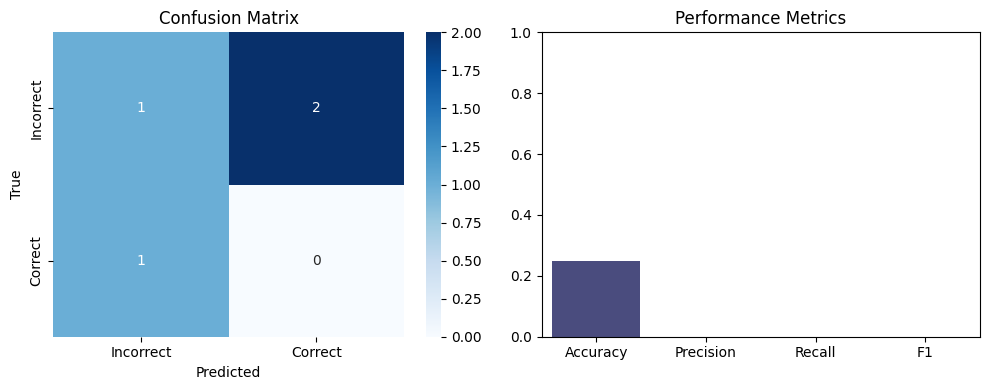

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.00      0.00      0.00         1

    accuracy                           0.25         4
   macro avg       0.25      0.17      0.20         4
weighted avg       0.38      0.25      0.30         4


ROC AUC Score: 0.16666666666666669


In [50]:
def run_demo():
    print("Design Assistant initialized!\n")

    y_true = []
    y_pred = []

    print("\nEnter your design questions (type 'exit' to quit):")
    while True:
        try:
            query = input("\nQuestion: ")
            if query.lower() in ['exit', 'quit']:
                break

            # Retrieve relevant documents
            retrieved_docs = retrieve_faiss(query, embed_model, index, doc_ids, texts)
            context = "\n\n".join([doc['text'] for doc in retrieved_docs])

            # Generate answer
            answer = generate_answer(query, context)

            # Format output
            print("\n" + "="*50)
            print(f"Query: {query}")
            print(f"Retrieved Context:\n{textwrap.fill(context, width=100)}")
            print("-"*50)
            print(f"Answer:\n{textwrap.fill(answer, width=100)}")
            print("="*50)

            # Get user feedback (true label)
            while True:
                try:
                    label = int(input("Was the answer correct? (1 for Yes, 0 for No): "))
                    if label in [0,1]:
                        break
                    else:
                        print("Invalid input. Enter 1 for Yes or 0 for No.")
                except ValueError:
                    print("Invalid input. Enter 1 for Yes or 0 for No.")

            # Store true label and prediction
            y_true.append(label)
            prediction = parse_correctness(answer)  # Simulated prediction
            y_pred.append(prediction)

            # Evaluate performance so far
            evaluate_agent(y_true, y_pred)

        except KeyboardInterrupt:
            break


if __name__ == "__main__":
    run_demo()